In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import sklearn.model_selection
import sklearn.metrics
from sklearn.ensemble import RandomForestRegressor
from sklearn.inspection import plot_partial_dependence
from sklearn.feature_selection import mutual_info_regression

import sklego.preprocessing

from fairness import fairestimator, utils

np.random.seed(42)

# Dealing with more complex biases: continuous attributes and non-linear bias
## Many bias mitigation strategies only work for monotonic biases
In the first notebook (https://github.com/SjoerdCor/fairness/blob/main/IntroducingTheIgnoringEstimator.ipynb), we introduced the IgnoringBiasEstimator, which was shown to work great to remove the disparate treatment between two groups. However, in that example, and in fact in many others concerning AI Fairness, the sensitive attribute was binary (Gender 1 vs Gender 2). In fact, many examples indeed artifically make columns binary, for instance by discretizing based on whether the value is larger or smaller than the mean, median or a custom value (e.g. [aif360](https://nbviewer.jupyter.org/github/Trusted-AI/AIF360/blob/master/examples/tutorial_credit_scoring.ipynb), [scikit-lego](https://scikit-lego.readthedocs.io/en/latest/fairness.html)). 

This is a problem if the biases are not monotonic and/or correlated with other, possibly sensitive attributes. It is easy to imagine a real-world scenario where middle-aged people are privileged over both juniors and seniors, or females between 25 and 35 being disadvantaged because of possible maternity leave.

In this notebook, I'll show two problems with most current approaches:
* Algorithms fail to reduce the bias (fully). 
* Even more worryingly, _we even fail to recognize there is a bias in our algorithm_ by oversimplifying the problem.

To show this, we generate a toy dataset where the salary of an employee depends on education, experience (correlated with age) and social skills, as desired, but also, undesirably, on the age of an employee. Middle-aged employees have higher salaries than younger and older employees
#TODO: add a data generating process figure

In [2]:
def generate_employees_age(size=2500):
    X = (pd.DataFrame({'Age': 25 + 40 * np.random.rand(size),
                       'Education': 4 + 16 * np.random.rand(size),
                       'SocialSkills': np.random.rand(size)
                      }
                     )
         .assign(Experience = lambda df: df['Age'].sub(np.random.randint(15, 40, size=size)).clip(0).mul(np.random.rand(size)*2))
        )
    return X

def quadratic_bonus(age, effect_size=-800):
    new_age = age.sub(age.min()).div(age.max() - age.min()) # Transform to [0, 1]
    new_age = new_age*2 - 1 # Transform [0, 1] -> [-1, 1]
    bias = effect_size * (0.5 - new_age**2) # Make the effect half-positive and half-negative for same mean
    bias -= bias.mean() # Make  the bias neutral
    return bias

def add_salaries_age(df):
    weights = {'Age': 0,
               'Education': 150,
               'Experience': 20,
               'SocialSkills': 1000
              }
    error = np.random.normal(0, 150, size=len(df))
    df = df.assign(SalarySkill = lambda df: df.mul(weights).sum('columns').add(error),
                   SalaryTrue = lambda df: df['SalarySkill'].sub(quadratic_bonus(df['Age'])))
    return df

In [3]:
df_age = generate_employees_age().pipe(add_salaries_age)
display(df_age.sample(10)) # TODO: display nicely
X_age_train, X_age_test, y_age_train, y_age_test, y_age_skill_train, y_age_skill_test = sklearn.model_selection.train_test_split(
                                                                                                         df_age.filter(['Age', 'Education', 'SocialSkills', 'Experience']),
                                                                                                         df_age['SalaryTrue'],
                                                                                                         df_age['SalarySkill'])

,Age,Education,SocialSkills,Experience,SalarySkill,SalaryTrue
1204,44.545728,19.154583,0.090419,5.607798,3209.319755,3480.527788
2420,31.400997,19.232999,0.196234,0.353339,3075.785140,2974.817349
1891,41.059773,12.660322,0.900760,1.576721,2672.637561,2912.734958
2201,29.428824,5.173825,0.135517,17.817374,1183.182974,966.528422
279,56.831707,7.346967,0.343027,19.694974,1807.989300,1799.861149
2184,51.126512,16.408085,0.228100,6.097842,2940.120148,3137.073848
1213,56.792382,13.963033,0.350710,18.875184,2909.746150,2903.478859
1173,35.392143,5.785488,0.836440,8.037224,1703.955934,1789.329511
511,41.729721,8.602124,0.927746,5.201312,2317.584354,2567.447893
1615,51.779478,9.455337,0.728494,9.128072,2460.837021,2640.941170


We see that the observed salary increases with age until the age of ~45 and then starts to decrease, albeit slower than the increase before 45. This is a combination of experience being larger and larger and the bias that benefits middle-aged people. 

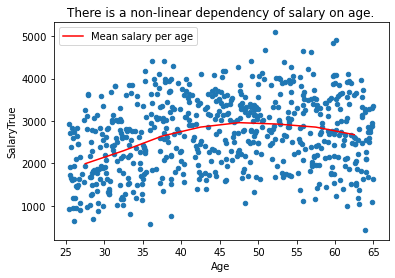

In [4]:
ax = (df_age
      .sample(frac=0.25)  # Less cluttered visualization
      .plot(kind='scatter', x='Age', y='SalaryTrue', title='There is a non-linear dependency of salary on age.')
     )
(df_age
 .assign(Age = lambda df: df['Age']//5*5 + 2.5).groupby('Age')['SalaryTrue'].mean()
 .plot(ax=ax, c='r', label='Mean salary per age')
)
plt.legend()
plt.show()

## Dividing continous attributes into buckets can hide the bias
First, let's look into the simplest solution. We train a model on all features, and check whether salaries of people are biased with for people older than the median with respect to people younger than the median.

While we used `LinearRegression` in the previous installment, here we switch to a `RandomForestRegressor` because of the non-linear nature.

In [5]:
rf =  RandomForestRegressor()
rf.fit(X_age_train, y_age_train)
y_age_pred = utils.predict_series(rf, X=X_age_test)
y_age_bias = y_age_pred.sub(y_age_skill_test).rename('BiasNaive')

In [6]:
biases = pd.concat([X_age_test['Age'], y_age_bias], axis='columns')

In [1]:
young_old_boundary = X_age_train['Age'].median() # We must use the same boundary for train and test

predictions = {'No bias mitigation': y_age_pred,
                }

utils.plot_fairness_metrics(predictions, y_age_skill_test, X_age_test['Age'].gt(young_old_boundary))
plt.suptitle('Fairness measures based on discretizing the protected attribute\nfalsely suggest there is no disparate treatment', y=1.1)
plt.show()

NameError: name 'X_age_train' is not defined

We see that that the disparate treatment is within the error bars, and we could conclude there is no significant bias from a binary measure. But this is wrong! Let's see what happens when we look at the continuous feature. As a measure of bias, we use the [mutual information criterion](https://en.wikipedia.org/wiki/Mutual_information), which can also pick up on biases that are non-linear, so that we can at least see when the estimator is biased.

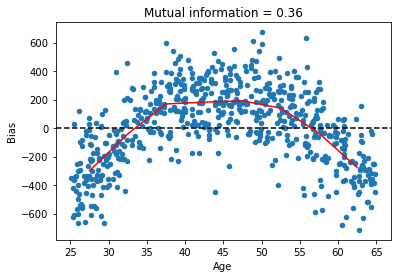

In [25]:
def plot_age_bias(biases, name):
    mutual_info = mutual_info_regression(biases[['Age']], biases[name])[0]
    ax = biases.plot(x='Age', y=name, kind='scatter', title=f'Mutual information = {mutual_info:.2f}')
    ax.axhline(0, c='k', ls='--')
    biases.assign(Age = lambda df: df['Age']//5 * 5 + 2.5).groupby('Age')[name].mean().plot(ax=ax, c='r')
    plt.ylabel('Bias')
    return ax

plot_age_bias(biases, 'BiasNaive')
plt.show()

Wee see clearly the advantage that middle-aged people have over both younger and older colleauges. In fact, we can see in the [partial dependence plot](https://scikit-learn.org/stable/modules/generated/sklearn.inspection.plot_partial_dependence.html) that that is precisely what the estimator has learned! This worries me a lot. One of the drivers of data science in the last few years is the enormous growth of volume of data, which allows us to easily fit complex, non-parametric models which pick up all sorts of correlations and non-linearities which lead to good performance. And then when it comes to fairness, a lot of proposed strategies that can not even deal with a simple quadratic dependency and perhaps even fail to detect it.

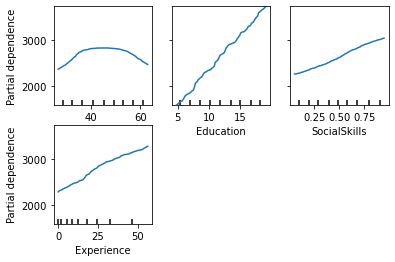

In [26]:
plot_partial_dependence(rf, X_age_train, X_age_train.columns)
plt.show()

## Many approaches fail to deal with non-linear biases
So already we see the importance of keeping continuous attributes. While already with the (otherwise great) `aif360`-package we have to define groups which are (un)priviliged, this becomes very hard - perhaps for this example we could make 3 age groups: juniors, middle-aged and seniors, this does not scale to more complex biases. Another approach is the one implemented in [scikit-lego](https://scikit-lego.readthedocs.io/en/latest/fairness.html), where the data is transformed through an "InformationFilter" using a [Gram-Schmidt process](https://en.wikipedia.org/wiki/Gram%E2%80%93Schmidt_process) so that the remaining dataset should not correlate with the sensitive attributes anymore. Let's see how that works out.

In [27]:
inf_filter = sklego.preprocessing.InformationFilter(['Age'])

In [28]:
X_train_inffilter = inf_filter.fit_transform(X_age_train)
X_train_inffilter = pd.DataFrame(X_train_inffilter, index=X_age_train.index)
X_test_inffilter = inf_filter.transform(X_age_test)
X_test_inffilter = pd.DataFrame(X_test_inffilter, index=X_age_test.index)

In [29]:
rf =  RandomForestRegressor(random_state=42)
rf.fit(X_train_inffilter, y_age_train)
y_age_pred = utils.predict_series(rf, X=X_test_inffilter)
biases['BiasInformationFilter'] = y_age_pred.sub(y_age_skill_test)

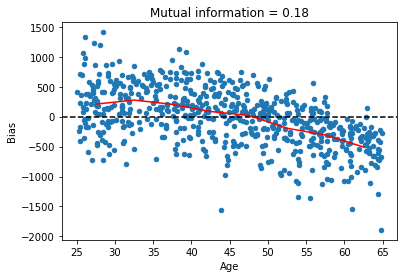

In [30]:
def plot_age_bias(biases, name):
    mutual_info = mutual_info_regression(biases[['Age']], biases[name])[0]
    ax = biases.plot(x='Age', y=name, kind='scatter', title=f'Mutual information = {mutual_info:.2f}')
    ax.axhline(0, c='k', ls='--')
    biases.assign(Age = lambda df: df['Age']//5 * 5 + 2.5).groupby('Age')[name].mean().plot(ax=ax, c='r')
    plt.ylabel('Bias')
    return ax

plot_age_bias(biases, 'BiasInformationFilter')
plt.show()

While the bias is less than it was, it's not removed at all.

The other approach turns the regression into a classification problem - which is not what we were after.

As I mentioned, all the `aif360` examples are also about classification problems.

## A better approach: The IgnoringEstimator solves non-linear problem out-of-the-box.

Luckily, this doesn't even have to be hard. 

Here again we can use the IgnoringEstimator, which learns the non-linear bias but does not use it at prediction. Additionally, we specify a `correction_strategy`: by default the model imputes the mean value for senstive columns, but in our case, the mean age has a positive bias which would lead to generally overestimated salaries. By specifying a correction strategy, the model subtracts the mean overprediction from each prediction to compensate for this. Other correction strategies are also implemented.

In [37]:
ib = fairestimator.IgnoringBiasRegressor(RandomForestRegressor(random_state=42),
                                         ignored_cols=[0], # Ignore the zeroeth column at prediction time -> Age
                                         correction_strategy='Additive') 
ib.fit(X_age_train, y_age_train)

In [38]:
y_age_pred_ic = utils.predict_series(ib, X=X_age_test)
y_age_bias_ic = y_age_pred_ic.sub(y_age_skill_test).rename('BiasIC')
biases['BiasIC'] = y_age_bias_ic

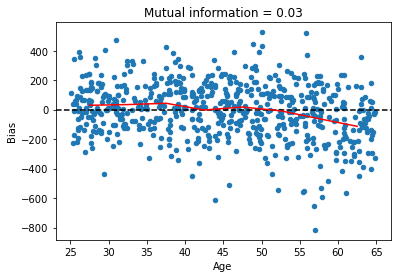

In [39]:
plot_age_bias(biases, 'BiasIC')
plt.show()

And with almost no effort, there is basically nothing left of the bias.